In [4]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table align="left">
</td>
<td style="text-align: center">
<a href="https://console.cloud.google.com/vertex-ai/workbench/instances/create?download_url=https://raw.githubusercontent.com/GoogleCloudDataproc/cloud-dataproc/ai-ml-samples/interactive/ImageClassificationInSpark.ipynb">
<img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
</a>
</td>
<td style="text-align: center">
<a href="https://github.com/GoogleCloudDataproc/cloud-dataproc/ai-ml-samples/interactive/ImageClassificationInSpark.ipynb">
<img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
</a>
</td>
</table>

## Overview

In this tutorial, you build a pipeline for predicting customer churn using [Apache Spark](https://spark.apache.org/), [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html), and the [Hugging Face Transformers](https://huggingface.co/docs/transformers/en/index) library. 

This tutorial is intended to run on [Dataproc Serverless](https://cloud.google.com/dataproc-serverless/docs/guides/create-serverless-sessions-templates) on Google Cloud.

## Get started

1. Create a dataproc-enabled [Vertex AI workbench instance](https://cloud.google.com/vertex-ai/docs/workbench/instances/create-dataproc-enabled) or use an existing instance.
2. Enable [Private Google Access](https://cloud.google.com/dataproc-serverless/docs/concepts/network#private-google-access-requirement) on a subnet in your project.
3. Setup [Public NAT](https://cloud.google.com/nat/docs/set-up-manage-network-address-translation#create-nat-gateway) to download models from Hugging Face. See [External network access](https://cloud.google.com/dataproc-serverless/docs/concepts/network#subnetwork_requirements).
4. Create a [serverless runtime template](https://cloud.google.com/dataproc-serverless/docs/quickstarts/jupyterlab-sessions#dataproc_create_serverless_runtime_template-JupyterLab) and connect to a [remote kernel](https://cloud.google.com/vertex-ai/docs/workbench/instances/create-dataproc-enabled#serverless-spark).

Uncomment and run this cell if not using Dataproc Serverless version 1.2 or 2.2+.

In [ ]:
# pip install xgboost `transformers[torch]`

Import libraries.

In [ ]:
from google.cloud import bigquery
import pandas as pd

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import when, col, regexp_replace, trim
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, FloatType, IntegerType, StringType
from pyspark.sql.functions import col, isnan, when, count, lit, udf

from transformers import pipeline
from xgboost.spark import SparkXGBClassifier


Set a name for an existing [Cloud Storage](https://cloud.google.com/storage/docs/creating-buckets) bucket. 

In [5]:
BUCKET = "YOUR-BUCKET"

Set your project name.

In [ ]:
PROJECT_ID = "YOUR-PROJECT-ID"

## Data Transformations and Exploratory Analysis

Load the IBM Telco Customer Churn dataset.

In [11]:
# Specify the path to the CSV file in GCS
file_path = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/refs/heads/master/data/Telco-Customer-Churn.csv"

# Read the CSV file into a Spark DataFrame. Use pd.read_csv to read directly
# from an https link and then convert to Spark.
df = spark.createDataFrame(
    pd.read_csv(file_path)
)

Check for null values in the data, specifically in the `MonthlyCharges` and `TotalCharges` columns.

In [12]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in ["MonthlyCharges", "TotalCharges"]]).show()

+--------------+------------+
|MonthlyCharges|TotalCharges|
+--------------+------------+
|             0|           0|
+--------------+------------+

+--------------+------------+
|MonthlyCharges|TotalCharges|
+--------------+------------+
|             0|          11|
+--------------+------------+



Check if `MonthlyCharges` and `TotalCharges` have any misformated values.

In [13]:
df.select([count(when(col(c).cast("float").isNull(), c)).alias(c) for c in ["MonthlyCharges", "TotalCharges"]]).show()

+--------------+------------+
|MonthlyCharges|TotalCharges|
+--------------+------------+
|             0|          11|
+--------------+------------+



Drop null values and cast the remaining values to float in the `TotalCharges` column.

In [14]:
# Drop records where TotalCharges has null or string values that can't be cast to float
df = df.filter(col("TotalCharges").cast("float").isNotNull())

# Transform the data type of total_charges to float
df = df.withColumn("TotalCharges", col("TotalCharges").cast(FloatType()))

df.show(10)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

## Visualize the data

Visualize churn rates by account types.

<Axes: title={'center': 'Customer Count by Contract Type and Churn'}, xlabel='Contract'>

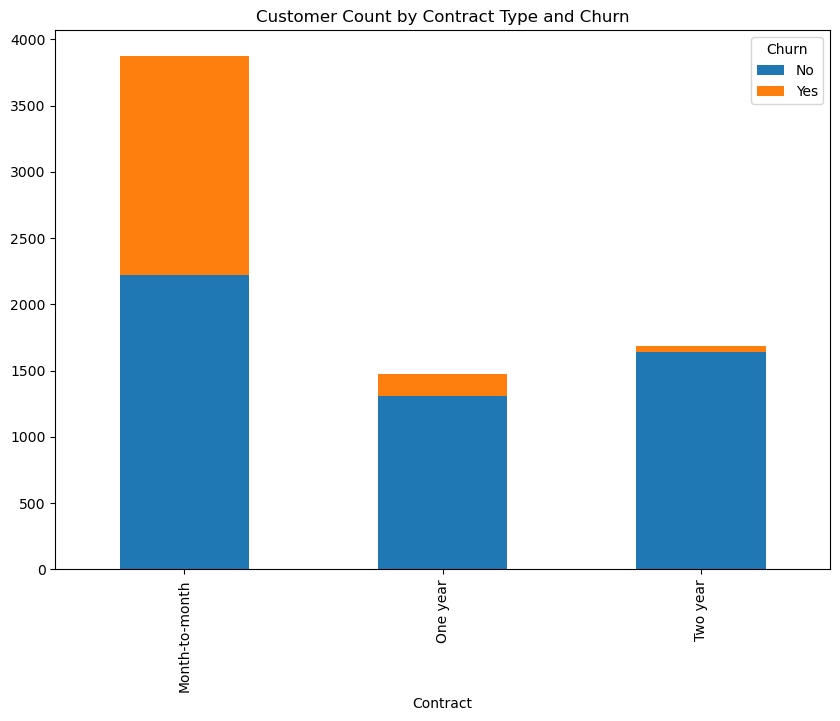

In [15]:
# Aggregate data
df_plot_data = df.groupBy("Contract", "Churn").count()

# Convert to Pandas DataFrame for plotting
pdf_plot_data = df_plot_data.toPandas()

# Pivot DataFrame to get "contract" as index, "churn" as columns, and "count" as values
pdf_pivoted = pdf_plot_data.pivot(index='Contract', columns='Churn', values='count')

# Plot
pdf_pivoted.plot(kind='bar', stacked=True, figsize=(10, 7), title="Customer Count by Contract Type and Churn")

Next, visualize churn rate by account tenure.

<Axes: title={'center': 'Account Tenure by Churn'}, xlabel='Tenure (Months)', ylabel='Count'>

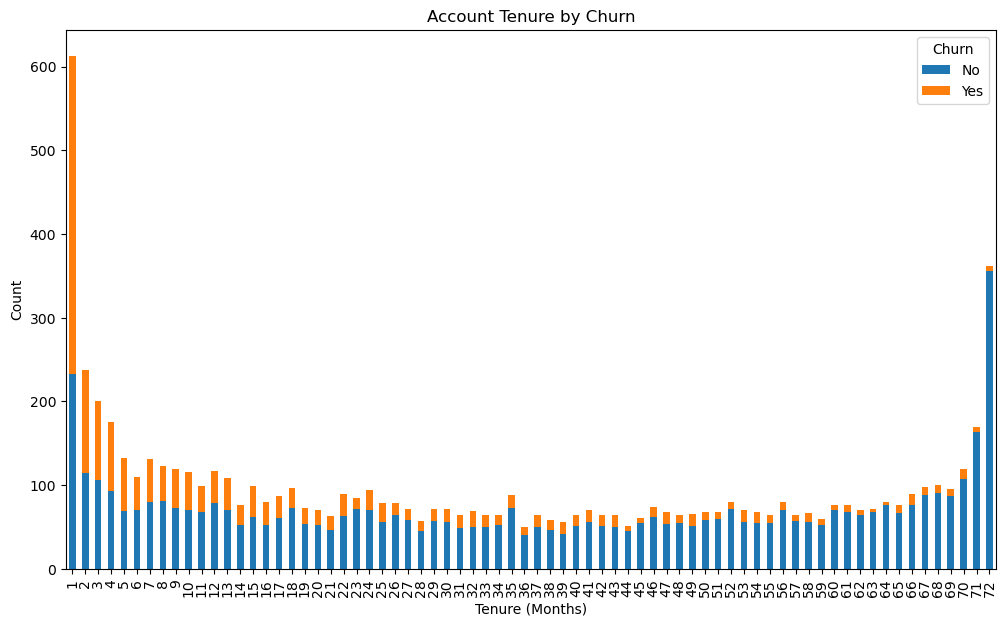

In [18]:
# Aggregate data
histogram_data = df.groupBy("Tenure", "Churn").count().orderBy("Tenure")

# Convert to Pandas DataFrame
pandas_histogram_data = histogram_data.toPandas()

# Pivot the data for stacked bar chart
pandas_histogram_data_pivot = pandas_histogram_data.pivot(index='Tenure', columns='Churn', values='count').fillna(0)

# Plot
pandas_histogram_data_pivot.plot(
    kind='bar', 
    stacked=True, 
    figsize=(12, 7),  # Adjust figure size as needed
    title="Account Tenure by Churn",
    xlabel="Tenure (Months)",
    ylabel="Count"
)

Convert account tenure into buckets, converting from monthly to yearly.

In [ ]:
# Bucket the "Tenure" field due to disribution
df = df.withColumn("TenureBucket", 
                                    when(col("Tenure") <= 12, "Tenure_0-12") \
                                    .when((col("Tenure") > 12) & (col("Tenure") <= 24), "Tenure_12-24") \
                                    .when((col("Tenure") > 24) & (col("Tenure") <= 48), "Tenure_24-48") \
                                    .when((col("Tenure") > 48) & (col("Tenure") <= 60), "Tenure_48-60") \
                                    .otherwise("Tenure_GT_60"))

# Drop the original "Tenure" column
df = df.drop("Tenure")

# Transform boolean fields to "Yes" or "No" strings
for column in ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']:
    df = df.withColumn(column, when(col(column) == True, "Yes").otherwise("No"))

# Replace "No internet service" with "No" in specified columns
for column in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    df = df.withColumn(column, when(col(column) == "No internet service", "No").otherwise(col(column)))

# Change "Churn" values to 1 and 0
df = df.withColumn("Churn", when(col("Churn") == True, 1).otherwise(0)).cache()

## Unstructured data transformations
Perform sentiment analysis on a series of chat transcripts using a finetuned version of the [DistilBert model](https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).

In [11]:
# Specify the model name and revision - downloads from Huggingface
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
model_revision = "af0f99b" 

# Load pre-trained sentiment analysis model with specified model and revision
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name, revision=model_revision)

# Define a UDF to perform sentiment analysis
@udf(returnType=StringType())
def analyze_sentiment(text):
    result = sentiment_pipeline(text)[0]
    return result['label']

# Specify the path to the JSON file in GCS
file_path = f"gs://{BUCKET}/unstructured-data/output/chat_transcripts.json"

# Read the JSON file into a Spark DataFrame
df_sentiment = spark.read.json(file_path)

# Rename the "support_transcript" column to "text" (required for this particular model)
df_sentiment = df_sentiment.withColumnRenamed("support_transcript", "text")

# Remove records with null values for text
df_sentiment = df_sentiment.filter(df_sentiment["text"].isNotNull() & (df_sentiment["text"] != ""))

# Analyze the "support_transcript" field for sentiment and retain "customer_id"
df_sentiment = df_sentiment.withColumn("sentiment", analyze_sentiment(df_sentiment["text"])).cache()

# Display the results
df_sentiment.show()

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

+----------+--------------------+---------+
|customerID|                text|sentiment|
+----------+--------------------+---------+
|7590-VHVEG|The customer was ...| NEGATIVE|
|5575-GNVDE|The customer was ...| NEGATIVE|
|3668-QPYBK|The customer was ...| POSITIVE|
|7795-CFOCW|The customer was ...| NEGATIVE|
|9237-HQITU|A quick and frien...| POSITIVE|
|9305-CDSKC|A pleasant conver...| POSITIVE|
|1452-KIOVK|The customer was ...| NEGATIVE|
|6713-OKOMC|The customer was ...| NEGATIVE|
|7892-POOKP|A friendly exchan...| POSITIVE|
|6388-TABGU|The customer was ...| NEGATIVE|
|9763-GRSKD|The customer was ...| NEGATIVE|
|7469-LKBCI|The customer was ...| NEGATIVE|
|8091-TTVAX|The customer was ...| NEGATIVE|
|0280-XJGEX|A friendly chat a...| POSITIVE|
|5129-JLPIS|The customer was ...| NEGATIVE|
|3655-SNQYZ|The customer was ...| NEGATIVE|
|8191-XWSZG|The customer was ...| NEGATIVE|
|9959-WOFKT|The customer was ...| NEGATIVE|
|4190-MFLUW|A friendly exchan...| POSITIVE|
|4183-MYFRB|The customer was ...

## Join data

Combine the transformed transcript data to the customer churn data, then save this to Cloud Storage.

In [15]:
# Join the transformed and sentiment data, and save to GCS

# Specify the output path in GCS
training_data_path = f"gs://{BUCKET}/curated/data/training_data"

# Join the DataFrames on customer_id
df_combined = df_sentiment.join(df, on="CustomerID", how="inner") 

# # Write the DataFrame to GCS in Parquet format
df_combined.write.format("parquet").mode("overwrite").save(output_path)

# Model Training and Evaluation

Next, you train an XGBoost model using the newly processed data. 

XGBoost does not support Spark's dynamic allocation feature. To use XGBoost, disable this first by restarting the Spark Session.

In [16]:
spark.stop()
spark = SparkSession.builder.config("spark.dynamicAllocation.enabled", "false").getOrCreate()

Load the data again in the new Spark Session.

In [17]:
df_train = spark.read.parquet(training_data_path)

## Perform feature engineering

Convert the data to be usable with SparkML and SparkXGBoost.
- String Indexers map the string samples in the data to numbers, which "shrinks" the size of the data being processed.
- One Hot Encoders convert the categorical data into sparse vectors.
- A Vector Assembler is used to format the data per SparkML's requirements.

In [25]:
categorical_cols = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                   'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                   'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
                   'PaperlessBilling', 'PaymentMethod', 'TenureBucket', 'sentiment']
numerical_cols = ['SeniorCitizen', 'MonthlyCharges', 'TotalCharges'] 

indexers = [StringIndexer(inputCol=c, outputCol=c + "_index", handleInvalid="keep") for c in categorical_cols]  
encoders = [OneHotEncoder(inputCol=c + "_index", outputCol=c + "_encoded", handleInvalid="keep") for c in categorical_cols] 

assembler = VectorAssembler(inputCols=[c + "_encoded" for c in categorical_cols] + numerical_cols, outputCol="features", handleInvalid="keep") 

# Apply transformations:
indexed_df = Pipeline(stages=indexers).fit(df_train).transform(df_train)
encoded_df = Pipeline(stages=encoders).fit(indexed_df).transform(indexed_df)
transformed_data = assembler.transform(encoded_df)

## Train the model and generate predictions

Use the [SparkXGBoostClassifier](https://xgboost.readthedocs.io/en/latest/tutorials/spark_estimator.html#sparkxgbclassifier) to create a SparkML model. This is passed into a SparkML [pipeline](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.Pipeline.html) object.

In [3]:
xgb = SparkXGBClassifier(label_col="churn", features_col="features", num_workers=2, missing=0.0)

pipeline = Pipeline(stages=[xgb])

NameError: name 'SparkXGBClassifier' is not defined

Split the data into training and test datasets.

In [2]:
train_data, test_data = transformed_data.randomSplit([0.8, 0.2], seed=42) 

NameError: name 'transformed_data' is not defined

Fit the model using the training data.

In [ ]:
model = pipeline.fit(train_data)
print("Model training successful.")

Generate predictions on the test data.

In [ ]:
predictions = model.transform(test_data)

## Evaluate the model.

Evaluate the performance of the model. The metrics used are:
- [AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
- PRC
- [Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall#accuracy)
- [F1 score](https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall#expandable-2)
- [Precision](https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall#precision)
- [Recall](https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall#recall_or_true_positive_rate)

In [ ]:
evaluator_binary = BinaryClassificationEvaluator(labelCol="churn", rawPredictionCol="rawPrediction")
auc = evaluator_binary.evaluate(predictions, {evaluator_binary.metricName: "areaUnderROC"})
print(f"Area Under ROC (AUC): {auc:.4f}")

prc = evaluator_binary.evaluate(predictions, {evaluator_binary.metricName: "areaUnderPR"})
print(f"Area Under PR Curve (PRC): {prc:.4f}")

evaluator_multi = MulticlassClassificationEvaluator(labelCol="churn", predictionCol="prediction")
accuracy = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "accuracy"})
print(f"Accuracy: {accuracy:.4f}")

f1 = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "f1"})
print(f"F1 Score: {f1:.4f}")

weighted_precision = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedPrecision"})
print(f"Weighted Precision: {weighted_precision:.4f}")

weighted_recall = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedRecall"})
print(f"Weighted Recall: {weighted_recall:.4f}")

## Save to Cloud storage

Save the train data, test data, and XGBoost model to Cloud storage.

In [ ]:
# Specify GCS bucket training data path
data_path = f"gs://{bucket}/curated/models/churn_prediction"

# Save transformed training data
train_data.write.parquet(f"{data_path}/train_data", mode="overwrite")

# Save transformed test data
test_data.write.parquet(f"{data_path}/test_data", mode="overwrite")

# Save the trained model to GCS:
model.write().overwrite().save(f"{data_path}/xgboost_model")

# Run Batch Inference on Spark

Load the model and test data from Cloud Storage into Spark.

In [ ]:
# Specify my GCP bucket
model_bucket = f"gs://{BUCKET}/curated/models/churn_prediction"

# Load transformed training data
test_data_loaded = spark.read.parquet(f"{model_bucket}/test_data")

# Load the trained model
model_loaded = PipelineModel.load(f"{model_bucket}/xgboost_model")

Generate predictions on the test data.

In [ ]:
predictions = model_loaded.transform(test_data_loaded)

# Filter down to only include the customer_id and prediction columns
predictions = predictions.select("customer_id", "prediction")

# Display sample data
predictions.show()

### Save predictions to BigQuery

Create a BigQuery dataset to store your predictions in.

In [ ]:


# Construct a BigQuery client object.
client = bigquery.Client()

# Set dataset_id to the ID of the dataset to create.
dataset_id = f"{PROJECT_ID}.predictions"

# Construct a full Dataset object to send to the API.
dataset = bigquery.Dataset(dataset_id)

# TODO(developer): Specify the geographic location where the dataset should reside.
dataset.location = "us-central1"

# Send the dataset to the API for creation, with an explicit timeout.
dataset = client.create_dataset(dataset, timeout=30)  # Make an API request.

Save the predictions directly from Spark to BigQuery.

In [ ]:
# Define table name to save predictions
table_name = 'predictions'

# Write predictions DataFrame to a Delta table
predictions.write \
    .format("bigquery") \
    .mode("overwrite") \
    .option("writeMethod", "direct") \
    .save(f'{dataset_id}.{table_name}')